In [ ]:
# # CS 510 — Assignment 2
# ## Sentiment Classification with Llama 3.2
# ### author: Ahmad Agah

In [ ]:
# SECTION 1 — Device diagnostics & selection
import os
import platform
import sys
import torch


def _mps_flags():
    """Return (is_built, is_available) for Apple Metal (MPS)."""
    mps = getattr(torch.backends, "mps", None)
    is_built = bool(mps and getattr(mps, "is_built", lambda: False)())
    is_available = bool(mps and getattr(mps, "is_available", lambda: False)())
    return is_built, is_available


def pick_device(prefer_cuda: bool = True) -> torch.device:
    """
    Cross-platform: CUDA↔MPS priority switch.
    Env override: DEVICE in {"cpu","cuda","cuda:1","mps"}.
    """
    override = os.getenv("DEVICE")
    if override:
        return torch.device(override)

    _, mps_avail = _mps_flags()
    order = ("cuda", "mps") if prefer_cuda else ("mps", "cuda")
    for dev in order:
        if dev == "cuda" and torch.cuda.is_available():
            return torch.device("cuda")
        if dev == "mps" and mps_avail:
            return torch.device("mps")
    return torch.device("cpu")

# Diagnostics
print("Python:", sys.version.replace("\n", " "))
print("Executable:", sys.executable)
print("Platform:", platform.platform())
print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

mps_built, mps_avail = _mps_flags()
print("MPS built:", mps_built)
print("MPS available:", mps_avail)

device = pick_device()
print("Device:", device)

# Nice-to-have extras
if device.type == "cuda":
    print("CUDA device count:", torch.cuda.device_count())
    print("CUDA device name:", torch.cuda.get_device_name(0))

Python: 3.13.7 (main, Aug 14 2025, 11:12:11) [Clang 17.0.0 (clang-1700.0.13.3)]
Executable: /Users/ahmadagah/Desktop/fall25/llm/prog#2/.venv/bin/python
Platform: macOS-15.7.1-arm64-arm-64bit-Mach-O
Torch version: 2.9.0
CUDA available: False
MPS built: True
MPS available: True
Device: mps


In [ ]:
# SECTION 2 — Config (.env), seeding, dtype

import os
import random
from typing import Optional
from dotenv import load_dotenv
import numpy as np

load_dotenv()  # loads variables from .env into environment



# -------- ENV HELPERS --------
class ConfigError(RuntimeError): pass

def _get_env(name: str, *, default=None, required: bool=False) -> str:
    v = os.getenv(name, default)
    if required and (v is None or v == ""):
        raise ConfigError(f"Missing required env var: {name}")
    return v

def _get_bool(name: str, default: bool=False) -> bool:
    return os.getenv(name, str(default)).lower() in {"1", "true", "yes", "on"}

def _get_int(name: str, default: int) -> int:
    try:
        return int(os.getenv(name, default))
    except ValueError:
        raise ConfigError(f"Env var {name} must be an integer")


# -------- CONFIG (loaded from .env) --------
HF_TOKEN: Optional[str] = _get_env("HF_TOKEN", required=True)           # required secret
MODEL_ID: str = _get_env("MODEL_ID", default="meta-llama/Llama-3.2-1B-Instruct")
SEED: int = _get_int("SEED", 42)
PREFER_CUDA: bool = _get_bool("PREFER_CUDA")                      # optional switch


# -------- SEED + DTYPE --------
def set_seed(seed: int, device: torch.device) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if device.type == "cuda":
        torch.cuda.manual_seed_all(seed)

def get_dtype(device: torch.device) -> torch.dtype:
    return torch.float16 if device.type in ("cuda", "mps") else torch.float32


# Apply seeding and compute dtype
set_seed(SEED, device)
DTYPE: torch.dtype = get_dtype(device)

In [ ]:
# SECTION 3 — Load dataset (CardiffNLP tweet sentiment, English subset)
from datasets import ClassLabel, Features, Value, load_dataset


def load_cardiff_english():
    try:
        return load_dataset(
            "cardiffnlp/tweet_sentiment_multilingual",
            name="english",
            revision="main",
            download_mode="reuse_cache_if_exists",
        )
    except Exception:
        print("[INFO] Fallback to direct JSON URLs.", flush=True)
        base = "https://huggingface.co/datasets/cardiffnlp/tweet_sentiment_multilingual/resolve/main/data/english"
        data_files = {
            "train": f"{base}/train.jsonl",
            "validation": f"{base}/validation.jsonl",
            "test": f"{base}/test.jsonl",
        }
        ds = load_dataset("json", data_files=data_files)
        feats = Features({
            "text": Value("string"),
            "label": ClassLabel(names=["negative","neutral","positive"]),
        })
        return ds.cast(feats)

ds = load_cardiff_english()

sizes = {split: len(ds[split]) for split in ds}
print("Splits:", sizes)

label_names = ds["train"].features["label"].names
print("Labels:", label_names)

assert 1800 <= sizes.get("train", 0) <= 1900, f"Unexpected English train size: {sizes}"
assert  800 <= sizes.get("test", 0)  <=  900, f"Unexpected English test size: {sizes}"

test_texts  = [row["text"] for row in ds["test"]]
test_labels = [label_names[row["label"]] for row in ds["test"]]

print(f"Loaded {len(test_texts)} test examples and {len(test_labels)} labels.")
print ("Example text:", test_texts[0:5])
print("First 5 test labels:", test_labels[0:5])

Using the latest cached version of the dataset since cardiffnlp/tweet_sentiment_multilingual couldn't be found on the Hugging Face Hub


[INFO] Fallback to direct JSON URLs.
Splits: {'train': 1839, 'validation': 324, 'test': 870}
Labels: ['negative', 'neutral', 'positive']
Loaded 870 test examples and 870 labels.
Example text: ['Trying to have a conversation with my dad about vegetarianism is the most pointless infuriating thing ever #caveman ', '#latestnews 4 #newmexico #politics + #nativeamerican + #Israel + #Palestine  -  Protesting Rise Of Alt-Right At... ', '@user You are a stand up guy and a Gentleman Vice President Pence ', "@user @user @user Looks like Flynn isn't too pleased with me, he blocked me. You blocked by Flynn too @user ", 'perfect pussy clips #vanessa hudgens zac efron naked ']
First 5 test labels: ['negative', 'neutral', 'positive', 'negative', 'neutral']


In [ ]:
# SECTION 4 — Load model & tokenizer
from transformers import AutoModelForCausalLM, AutoTokenizer, GenerationConfig, pipeline

tok = AutoTokenizer.from_pretrained(MODEL_ID, token=HF_TOKEN)
model = AutoModelForCausalLM.from_pretrained(MODEL_ID, token=HF_TOKEN, dtype=DTYPE)
model.to(device)
print("Model loaded on:", next(model.parameters()).device)

gen = pipeline("text-generation", model=model, tokenizer=tok)

# Greedy generation (one token)
gen.generation_config = GenerationConfig(
    do_sample=False,
    max_new_tokens=1,
    eos_token_id=tok.eos_token_id,
    pad_token_id=tok.eos_token_id,
)

Device set to use mps:0


Model loaded on: mps:0


In [ ]:
# SECTION 5 — Prompt helpers: parsing + batched prediction

import re
import time
from tqdm.auto import tqdm
from sklearn.metrics import classification_report

# Case-insensitive match for exactly these three words
ANS_RE = re.compile(r"\b(positive|neutral|negative)\b", re.I)

def parse_label(text: str) -> str:
    """
    Extract one of {positive, neutral, negative} from model output.
    Falls back to 'neutral' if nothing is detected.
    """
    m = ANS_RE.search(text)
    return m.group(1).lower() if m else "neutral"

def predict_texts(texts, prompt_builder, batch_size=32, show_progress=True):
    """
    Build prompts → run generation in batches → parse labels.
    - prompt_builder: function str -> str that returns a full prompt
    - returns a list of labels: ['positive'|'neutral'|'negative', ...]
    """
    prompts = [prompt_builder(t) for t in texts]
    preds = []
    n = len(prompts)

    rng = range(0, n, batch_size)
    if show_progress:
        rng = tqdm(rng, desc="Zero-shot", unit="batch")

    with torch.inference_mode():
        for i in rng:
            batch = prompts[i:i + batch_size]
            # HF text-generation pipeline returns a nested list:
            #   [ [ {"generated_text": "..."} ], [ {"generated_text": "..."} ], ... ]
            outs = gen(batch, return_full_text=False, num_return_sequences=1)
            for seqs in outs:
                preds.append(parse_label(seqs[0]["generated_text"]))

            # Force sync on MPS (Apple Silicon) so the bar & memory are accurate
            if device.type == "mps":
                torch.mps.synchronize()

    return preds

def print_report(title, y_true, y_pred, labels):
    """Nicely print per-class precision/recall/F1."""
    print(f"\n{title}\n")
    print(classification_report(y_true, y_pred, labels=labels, digits=3))

Zero-shot: 100%|██████████| 28/28 [01:04<00:00,  2.31s/batch]


ZERO-SHOT (original prompt) RESULTS

              precision    recall  f1-score   support

    negative      0.742     0.566     0.642       290
     neutral      0.484     0.310     0.378       290
    positive      0.562     0.897     0.691       290

    accuracy                          0.591       870
   macro avg      0.596     0.591     0.570       870
weighted avg      0.596     0.591     0.570       870


Summary — Accuracy: 0.591 | Macro-F1: 0.570


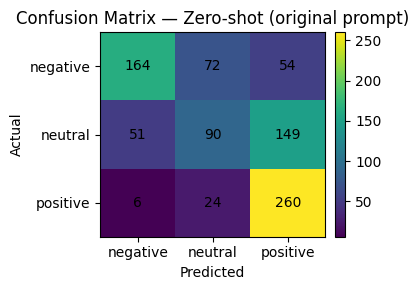

In [ ]:
# SECTION 6 — ZERO-SHOT (original prompt: determine polarity → label)
# Exact wording + exact order (Neutral, Positive, Negative)

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt

def zero_shot_prompt(tweet: str) -> str:
    return (
        "Task: Determine sentiment polarity.\n"
        "Output must be a single word label.\n"
        "Valid outputs: Neutral, Positive, Negative.\n"
        f'Input: "{tweet}"\n'
        "Label:"
    )

# Run zero-shot using YOUR original prompt
zs_preds = predict_texts(
    test_texts,
    zero_shot_prompt,
    batch_size=32,
    show_progress=True,
)

# Classification report
print_report("ZERO-SHOT (original prompt) RESULTS", test_labels, zs_preds, label_names)

# Quick summary
acc = accuracy_score(test_labels, zs_preds)
macro = f1_score(test_labels, zs_preds, average="macro")
print(f"\nSummary — Accuracy: {acc:.3f} | Macro-F1: {macro:.3f}")

# Confusion matrix
cm = confusion_matrix(test_labels, zs_preds, labels=label_names)
fig, ax = plt.subplots(figsize=(4,3))
im = ax.imshow(cm, aspect="auto")
ax.set_title("Confusion Matrix — Zero-shot (original prompt)")
ax.set_xlabel("Predicted"); ax.set_ylabel("Actual")
ax.set_xticks(range(len(label_names))); ax.set_yticks(range(len(label_names)))
ax.set_xticklabels(label_names); ax.set_yticklabels(label_names)
for i in range(len(label_names)):
    for j in range(len(label_names)):
        ax.text(j, i, cm[i, j], ha="center", va="center")
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout(); plt.show()


=== Running best few-shot config for k=1 ===


Zero-shot: 100%|██████████| 28/28 [01:58<00:00,  4.22s/batch]


FEW-SHOT RESULTS (k=1)

              precision    recall  f1-score   support

    negative      0.633     0.831     0.718       290
     neutral      0.594     0.414     0.488       290
    positive      0.753     0.745     0.749       290

    accuracy                          0.663       870
   macro avg      0.660     0.663     0.652       870
weighted avg      0.660     0.663     0.652       870

k=1 | style=instruction_minimal | order=Positive/Neutral/Negative
  Accuracy : 0.663
  Macro-F1 : 0.652
  Micro-F1 : 0.663


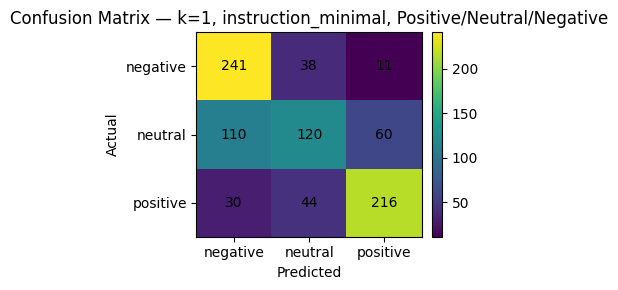


=== Running best few-shot config for k=2 ===


Zero-shot: 100%|██████████| 28/28 [03:03<00:00,  6.54s/batch]



FEW-SHOT RESULTS (k=2)

              precision    recall  f1-score   support

    negative      0.590     0.872     0.704       290
     neutral      0.600     0.393     0.475       290
    positive      0.777     0.672     0.721       290

    accuracy                          0.646       870
   macro avg      0.656     0.646     0.633       870
weighted avg      0.656     0.646     0.633       870

k=2 | style=instruction_minimal | order=Positive/Neutral/Negative
  Accuracy : 0.646
  Macro-F1 : 0.633
  Micro-F1 : 0.646


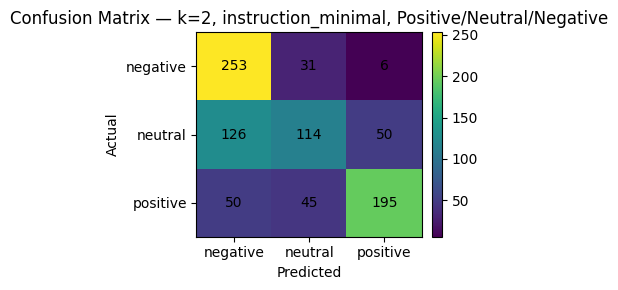


=== Running best few-shot config for k=3 ===


Zero-shot: 100%|██████████| 28/28 [04:07<00:00,  8.83s/batch]


FEW-SHOT RESULTS (k=3)

              precision    recall  f1-score   support

    negative      0.663     0.814     0.731       290
     neutral      0.583     0.462     0.515       290
    positive      0.736     0.721     0.728       290

    accuracy                          0.666       870
   macro avg      0.660     0.666     0.658       870
weighted avg      0.660     0.666     0.658       870

k=3 | style=instruction_minimal | order=Neutral/Negative/Positive
  Accuracy : 0.666
  Macro-F1 : 0.658
  Micro-F1 : 0.666


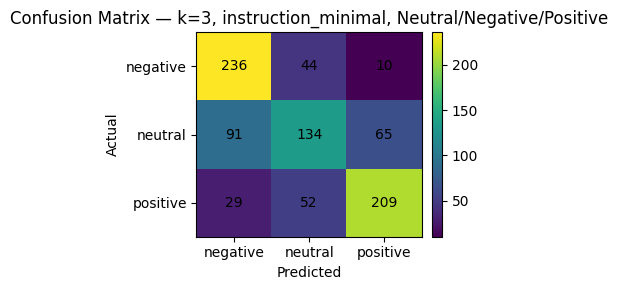

In [ ]:
# FEW-SHOT — Final best configs for k = 1, 2, 3
# Uses:
#   - ds["train"]        : training split with tweet text + labels
#   - label_names        : list like ["negative", "neutral", "positive"]
#   - test_texts         : full test texts
#   - test_labels        : full test labels (same order as test_texts)
#   - predict_texts(...) : your generation helper
#   - SEED               : global random seed

from collections import defaultdict
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import random
import matplotlib.pyplot as plt

# ---------------------------------------------------------------------
# 1. Global config: chosen best setups per k
# ---------------------------------------------------------------------

BEST_CONFIGS = {
    # k : (style_name, label_order)
    1: ("instruction_minimal", ("Positive", "Neutral", "Negative")),
    2: ("instruction_minimal", ("Positive", "Neutral", "Negative")),
    3: ("instruction_minimal", ("Neutral", "Negative", "Positive")),
}

BATCH_SIZE = 32
SHOW_CM = True  # set to False if you don’t want confusion matrices

train = ds["train"]


# ---------------------------------------------------------------------
# 2. Helper: collect k examples per class from train
# ---------------------------------------------------------------------
def collect_examples_per_class(k: int):
    """
    Return a dict:
        {
          "negative": [text1, text2, ...],
          "neutral" : [...],
          "positive": [...]
        }
    with exactly k examples per class (or fewer if train is tiny).
    Uses a deterministic shuffle with SEED.
    """
    rows = list(train)
    random.seed(SEED)
    random.shuffle(rows)

    ex = defaultdict(list)
    for r in rows:
        lbl = label_names[r["label"]]  # e.g. "negative"
        if len(ex[lbl]) < k:
            ex[lbl].append(r["text"])
        # stop once we have k for every label
        if all(len(ex[x]) >= k for x in label_names):
            break
    return ex


# ---------------------------------------------------------------------
# 3. Prompt builder — we only need instruction_minimal
# ---------------------------------------------------------------------
def build_instruction_minimal_prompt(order, tweet: str, shots: dict) -> str:
    """
    Build a compact few-shot prompt using the instruction_minimal style.

    order: tuple of label strings as you want them displayed
           e.g. ("Positive", "Neutral", "Negative")
    tweet: string to classify
    shots: dict from collect_examples_per_class, keys are lowercase
           "negative" / "neutral" / "positive"
    """
    # Show labels in the chosen order in the instruction line
    opts = ", ".join(order)

    parts = [f"One-word sentiment only: {opts}."]
    # Add k training examples for each class (order here is not critical)
    for lbl_lower, exs in shots.items():
        lbl_cap = lbl_lower.capitalize()  # "negative" -> "Negative"
        for ex in exs:
            parts.append(f'"{ex}" → {lbl_cap}')

    # Final line: the tweet we want to classify
    parts.append(f'"{tweet}" →')
    return "\n".join(parts)


# ---------------------------------------------------------------------
# 4. Run classification for a given k using its best config
# ---------------------------------------------------------------------
def classify_best_for_k(k: int):
    """
    Run the model on the full test set using the pre-selected
    best config for this k.

    Returns:
        preds   : list of predicted labels (strings like "Negative")
        metrics : dict with accuracy, macro_f1, micro_f1
    """
    style, order = BEST_CONFIGS[k]
    assert style == "instruction_minimal", "Only instruction_minimal is used here."

    # Few-shot examples
    shots = collect_examples_per_class(k)

    # Build prompts and run generation
    preds = predict_texts(
        test_texts,
        lambda tw, _order=order, _shots=shots: build_instruction_minimal_prompt(
            _order, tw, _shots
        ),
        batch_size=BATCH_SIZE,
        show_progress=True,  # show progress bar
    )

    # Compute metrics
    y_true = test_labels
    acc = accuracy_score(y_true, preds)
    macro = f1_score(y_true, preds, average="macro")
    micro = f1_score(y_true, preds, average="micro")  # ~ accuracy for multi-class

    metrics = {
        "accuracy": acc,
        "macro_f1": macro,
        "micro_f1": micro,
        "order": order,
        "style": style,
    }
    return preds, metrics


# ---------------------------------------------------------------------
# 5. Driver: run for k = 1, 2, 3 and (optionally) show confusion matrices
# ---------------------------------------------------------------------
all_results = {}

for k in [1, 2, 3]:
    print(f"\n=== Running best few-shot config for k={k} ===")
    preds, metrics = classify_best_for_k(k)
    all_results[k] = (preds, metrics)
    
    print_report(f"FEW-SHOT RESULTS (k={k})", test_labels, preds, label_names)

    ord_str = "/".join(metrics["order"])
    print(
        f"k={k} | style={metrics['style']} | order={ord_str}\n"
        f"  Accuracy : {metrics['accuracy']:.3f}\n"
        f"  Macro-F1 : {metrics['macro_f1']:.3f}\n"
        f"  Micro-F1 : {metrics['micro_f1']:.3f}"
    )

    if SHOW_CM:
        cm = confusion_matrix(test_labels, preds, labels=label_names)
        fig, ax = plt.subplots(figsize=(4, 3))
        im = ax.imshow(cm, aspect="auto")
        ax.set_title(f"Confusion Matrix — k={k}, {metrics['style']}, {ord_str}")
        ax.set_xlabel("Predicted")
        ax.set_ylabel("Actual")
        ax.set_xticks(range(len(label_names)))
        ax.set_yticks(range(len(label_names)))
        ax.set_xticklabels(label_names)
        ax.set_yticklabels(label_names)
        for i in range(len(label_names)):
            for j in range(len(label_names)):
                ax.text(j, i, cm[i, j], ha="center", va="center")
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        plt.tight_layout()
        plt.show()

In [ ]:
# SECTION 8 — EXPERIMENT 3: Fine-tuning on full train set (LoRA) + test eval

import os, math, time
from typing import Dict, List

import torch
from torch.utils.data import Dataset
from transformers import TrainingArguments, Trainer, PreTrainedTokenizerBase
from peft import LoraConfig, get_peft_model

# Quiet bitsandbytes + safer Apple GPU behavior
os.environ["BITSANDBYTES_NOWELCOME"] = "1"
if device.type == "mps":
    os.environ.setdefault("PYTORCH_MPS_HIGH_WATERMARK_RATIO", "0.0")


# ---------- 8.1  Label → first-token mapping (supervise only label token) ----------
_label_words = {"negative": "Negative", "neutral": "Neutral", "positive": "Positive"}

def _first_label_token_id(tok: PreTrainedTokenizerBase, word: str) -> int:
    # Prepend a space so tokenizer emits a clean wordpiece token
    ids = tok.encode(" " + word, add_special_tokens=False)
    return ids[0]

LABEL2TOK = {lbl: _first_label_token_id(tok, w) for lbl, w in _label_words.items()}


# ---------- 8.2  Build supervised LM examples: [PROMPT] + [label token] ----------
def _build_sup_ids(tweet_text: str, gold_label: str) -> Dict[str, List[int]]:
    # Reuse zero-shot prompt from Section 6
    prompt = zero_shot_prompt(tweet_text)
    # convert the entire prompt into a list of token IDs
    prompt_ids = tok.encode(prompt, add_special_tokens=False)
    # get the label token ID
    label_id = LABEL2TOK[gold_label]

    input_ids = prompt_ids + [label_id]
    attention_mask = [1] * len(input_ids)

    # Mask all prompt positions with -100, train only on last label token
    labels = [-100] * len(prompt_ids) + [label_id]

    return {"input_ids": input_ids, "attention_mask": attention_mask, "labels": labels}


class SupLMDataset(Dataset):
    """Turn (tweet, label) pairs into supervised LM examples for fine-tuning."""
    def __init__(self, texts: List[str], labels: List[str], max_length: int = 160):
        self.examples = []
        for t, y in zip(texts, labels):
            ex = _build_sup_ids(t, y)
            # Left-truncate if too long, keeping the label token
            for k in ("input_ids", "attention_mask", "labels"):
                if len(ex[k]) > max_length:
                    ex[k] = ex[k][-max_length:]
            self.examples.append(ex)

    def __len__(self) -> int:
        return len(self.examples)

    def __getitem__(self, idx: int) -> Dict[str, List[int]]:
        return self.examples[idx]


# ---------- 8.3  Pad-aware collator (pads labels with -100) ----------
def _pad_collate(batch: List[Dict[str, List[int]]]) -> Dict[str, torch.Tensor]:
    max_len = max(len(x["input_ids"]) for x in batch)
    pad_id = tok.eos_token_id

    input_ids, attention_mask, labels = [], [], []
    for x in batch:
        pad = max_len - len(x["input_ids"])
        input_ids.append(x["input_ids"] + [pad_id] * pad)
        attention_mask.append(x["attention_mask"] + [0] * pad)
        labels.append(x["labels"] + [-100] * pad)

    return {
        "input_ids": torch.tensor(input_ids, dtype=torch.long),
        "attention_mask": torch.tensor(attention_mask, dtype=torch.long),
        "labels": torch.tensor(labels, dtype=torch.long),
    }

# Make sure tokenizer has a pad token
if tok.pad_token_id is None:
    tok.pad_token = tok.eos_token


# ---------- 8.4  Build training dataset from full train split ----------
train_texts  = [row["text"] for row in ds["train"]]
train_labels = [label_names[row["label"]] for row in ds["train"]]
train_ds = SupLMDataset(train_texts, train_labels, max_length=160)  # shorter seqs → safer on MPS


# ---------- 8.5  Attach LoRA adapters to attention projections ----------
lora_cfg = LoraConfig(
    r=8,
    lora_alpha=16,
    lora_dropout=0.05,
    bias="none",
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj"],
    task_type="CAUSAL_LM",
)

model.config.use_cache = False # dont 
try:
    model.gradient_checkpointing_enable() # dont store activations, recompute some during backward
except Exception:
    pass

model = get_peft_model(model, lora_cfg)
model.print_trainable_parameters()  # verify only LoRA params are trainable


# ---------- 8.6  Trainer setup + hyperparameters ----------
LR = 2e-4
BATCH = 4
GRAD_ACC = 8            # effective batch ≈ 32
EPOCHS = 2
WEIGHT_DECAY = 0.0

args = TrainingArguments(
    output_dir="./ft_lora_outputs",
    per_device_train_batch_size=BATCH,
    gradient_accumulation_steps=GRAD_ACC,
    num_train_epochs=EPOCHS,
    learning_rate=LR,
    weight_decay=WEIGHT_DECAY,
    logging_steps=25,
    save_strategy="epoch",
    fp16=(device.type == "cuda"),   # MPS/CPU stay fp32
    dataloader_pin_memory=False,    # safer on MPS
    seed=SEED,
    optim="adamw_torch",
    gradient_checkpointing=True,
    report_to=[],
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_ds,
    tokenizer=tok,
    data_collator=_pad_collate,
)

steps_per_epoch = math.ceil(len(train_ds) / (BATCH * max(1, GRAD_ACC)))
trainer.create_optimizer_and_scheduler(num_training_steps=steps_per_epoch * EPOCHS)
opt_name = trainer.optimizer.__class__.__name__ if trainer.optimizer is not None else "AdamW (default)"

t0 = time.time()
trainer.train()
train_time = time.time() - t0


# ---------- 8.7  Evaluate fine-tuned model on SAME test set ----------
ft_preds = predict_texts(
    test_texts,
    lambda tw: zero_shot_prompt(tw),   # same style as Experiment 1, but now model is fine-tuned
    batch_size=32,
    show_progress=True,
)
print_report("FINE-TUNED (LoRA) RESULTS", test_labels, ft_preds, label_names)


# ---------- 8.8  Minimal summary for write-up ----------
print("\n=== Experiment 3 — Hyperparameters & Frameworks ===")
print("Frameworks: Hugging Face Transformers + PEFT (LoRA)")
print(f"Optimizer:          {opt_name}")
print(f"Learning rate:      {LR}")
print(f"Batch size (per-GPU): {BATCH}")
print(f"Grad accumulation:  {GRAD_ACC}  → Effective batch: {BATCH * GRAD_ACC}")
print(f"Weight decay:       {WEIGHT_DECAY}")
print(f"Epochs:             {EPOCHS}")
print(f"Seed:               {SEED}")
print(f"Training steps:     {steps_per_epoch * EPOCHS}")
print(f"Total train time:   {train_time:.1f}s")
print(f"Device:             {device}")


# ---------- 8.9  Optional: save adapters + tokenizer ----------
trainer.save_model("./ft_lora_outputs")
tok.save_pretrained("./ft_lora_outputs")

<ipython-input-27-b9cdefa638b0>:139: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 128009, 'pad_token_id': 128009}.


trainable params: 1,703,936 || all params: 1,237,518,336 || trainable%: 0.1377


Step,Training Loss
25,0.782800
50,0.704500
75,0.636400
100,0.558700


Zero-shot:   0%|          | 0/28 [00:00<?, ?batch/s]`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.
Caching is incompatible with gradient checkpointing in LlamaDecoderLayer. Setting `past_key_values=None`.
/Users/ahmadagah/Desktop/fall25/llm/prog#2/.venv/lib/python3.13/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
Zero-shot: 100%|██████████| 28/28 [01:11<00:00,  2.55s/batch]



FINE-TUNED (LoRA) RESULTS

              precision    recall  f1-score   support

    negative      0.633     0.910     0.747       290
     neutral      0.667     0.393     0.495       290
    positive      0.801     0.779     0.790       290

    accuracy                          0.694       870
   macro avg      0.700     0.694     0.677       870
weighted avg      0.700     0.694     0.677       870


=== Experiment 3 — Hyperparameters & Frameworks ===
Frameworks: Hugging Face Transformers + PEFT (LoRA)
Optimizer:          AdamW
Learning rate:      0.0002
Batch size (per-GPU): 4
Grad accumulation:  8  → Effective batch: 32
Weight decay:       0.0
Epochs:             2
Seed:               42
Training steps:     116
Total train time:   753.9s
Device:             mps


('./ft_lora_outputs/tokenizer_config.json',
 './ft_lora_outputs/special_tokens_map.json',
 './ft_lora_outputs/chat_template.jinja',
 './ft_lora_outputs/tokenizer.json')

In [ ]:
# SECTION 9 — Collect predictions for error analysis

import pandas as pd

# Get few-shot predictions: use best k if available, otherwise recompute k=3
if "all_results" in globals():
    FS_K = max(all_results.keys(), key=lambda k: all_results[k][1]["macro_f1"])
    fs_preds, fs_metrics = all_results[FS_K]
else:
    FS_K = 3
    fs_preds, fs_metrics = classify_best_for_k(FS_K)

print("Using few-shot k =", FS_K, "for error analysis")

# Build a DataFrame with text + true + all three predictions
df = pd.DataFrame({
    "text": test_texts,
    "true": test_labels,     # strings like "negative", "neutral", "positive"
    "zero_shot": zs_preds,   # zero-shot predictions
    "few_shot": fs_preds,    # few-shot predictions for chosen k
    "fine_tuned": ft_preds,  # fine-tuned (LoRA) predictions
})

print("DataFrame ready with", len(df), "test examples.")

Using few-shot k = 3 for error analysis
DataFrame ready with 870 test examples.


In [ ]:
# SECTION 10 — Example selection for qualitative analysis

# 1) Examples fixed by fine-tuning:
#    fine_tuned == true, but zero_shot or few_shot is wrong.
fixed_by_ft = df[
    (df["fine_tuned"] == df["true"]) &
    ((df["zero_shot"] != df["true"]) | (df["few_shot"] != df["true"]))
]

# 2) Examples misclassified by ALL three methods:
all_wrong = df[
    (df["zero_shot"] != df["true"]) &
    (df["few_shot"] != df["true"]) &
    (df["fine_tuned"] != df["true"])
]

print("Fixed by fine-tuning:", len(fixed_by_ft))
print("Misclassified by all three:", len(all_wrong))

print("\n=== 2 examples fixed by fine-tuning ===")
for _, row in fixed_by_ft.head(2).iterrows():
    print("\nTweet:", row["text"])
    print("True      :", row["true"])
    print("Zero-shot :", row["zero_shot"])
    print("Few-shot  :", row["few_shot"])
    print("Fine-tuned:", row["fine_tuned"])

print("\n=== 2 examples misclassified by ALL three ===")
for _, row in all_wrong.head(2).iterrows():
    print("\nTweet:", row["text"])
    print("True      :", row["true"])
    print("Zero-shot :", row["zero_shot"])
    print("Few-shot  :", row["few_shot"])
    print("Fine-tuned:", row["fine_tuned"])

Fixed by fine-tuning: 244
Misclassified by all three: 125

=== 2 examples fixed by fine-tuning ===

Tweet: @user @user @user Looks like Flynn isn't too pleased with me, he blocked me. You blocked by Flynn too @user 
True      : negative
Zero-shot : negative
Few-shot  : neutral
Fine-tuned: negative

Tweet: perfect pussy clips #vanessa hudgens zac efron naked 
True      : neutral
Zero-shot : positive
Few-shot  : negative
Fine-tuned: neutral

=== 2 examples misclassified by ALL three ===

Tweet: Presenting the Red Line symptoms of Aconite in two slides.I <3 Homeopathy 
True      : neutral
Zero-shot : positive
Few-shot  : positive
Fine-tuned: positive

Tweet: Go fight 4 REAL women's rights like 4 the ones who suffer in human trafficking or from being raped by rapeugees.Or… 
True      : neutral
Zero-shot : negative
Few-shot  : negative
Fine-tuned: negative
